In [236]:
import numpy as np
import re
import seaborn as sns
from math import log2

# 1. Mutual information statistic for pair of columns in a multiple alignment

In [288]:
# подсчет взаимной информации столбцов a и b

def info(a, b, nucl='U'): # nucl - можно использовать U или T
    assert len(a) == len(b)
    n = len(a)
    ind = {'A':0, nucl:1, 'G':2, 'C':3}
    P = np.zeros((5,5))
    for i in range(n):
        if a[i] != 'N' and b[i] != 'N':  # если нуклеотид не важен, то и информации он не несет
            P[ind[a[i]], ind[b[i]]] += 1
    for i in range(4):
        P[i,-1] = np.sum(P[i,:-1])
        P[-1,i] = np.sum(P[:-1,i])
    P /= n
    M = 0
    for i in range(4):
        for j in range(4):
            if not P[i,j]:
                continue
            M += P[i,j]*log2(P[i,j]/(P[i,-1]*P[-1,j]))
    return M

In [289]:
# матрица взаимной информации столбцов

def col_info(align, nucl='U'):
    n = np.shape(align)[1]
    M_inf = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            M_inf[i,j] = info(align[:,i], align[:,j], nucl=nucl)
    M_inf += M_inf.T

    return M_inf

In [290]:
# считываем последовательности из файла в матрицу (обязательный минимум ДЗ)

with open('column_info.txt', 'r') as f:
    matr = []
    for line in f:
        matr.append(list(line.rstrip()))
        
align = np.array(matr)

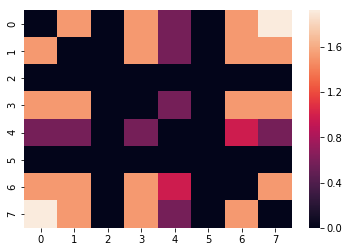

In [261]:
sns.heatmap(col_info(align))

### Сравним с точки зрения взаимной информации столбцы тРНК всех эукариот определенной длины

In [275]:
Dict = {}

# читаем FASTA файл
with open('eukaryotic-trnas.fa', 'r') as f:
    ID = ''
    for line in f:
        if re.match(r'\>.+', line):
            ID = re.match(r'\>(.+)', line).groups()[0]
            Dict[ID] = ''
            continue
        Dict[ID] += line.strip()

# находим длины имеющихся последовательностей
ln = {}
for item in Dict.items():
    ln[len(item[1])] = ln.get(len(item[1]), 0) + 1

# вычисляем длину для которой наибольшее кол-во последовательностей
best_len = sorted(ln.items(), key=lambda x: -x[1])[0][0] 

matr = []
for name in Dict:
    if len(Dict[name]) == best_len:
        matr.append(list(Dict[name].rstrip()))
        
align = np.array(matr)

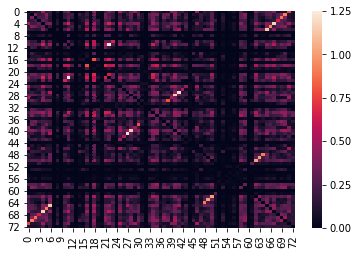

In [276]:
sns.heatmap(col_info(align, nucl='T'))

Четко видны четыре яркие линии, можно предположить что это четыре стебля тРНК, ченые полосы вероятно соответствуют петлям

### Проанализируем отдельно тРНК Homo sapiens

In [285]:
Dict = {}

# читаем FASTA файл
with open('eukaryotic-trnas.fa', 'r') as f:
    ID = ''
    for line in f:
        if re.match(r'\>Homo_sapiens.+', line):
            ID = re.match(r'\>(.+)', line).groups()[0]
            Dict[ID] = ''
            continue
        if re.match(r'Homo_sapiens.+', ID): 
            Dict[ID] += line.strip()

# находим длины имеющихся последовательностей
ln = {}
for item in Dict.items():
    ln[len(item[1])] = ln.get(len(item[1]), 0) + 1

# вычисляем длину для которой наибольшее кол-во последовательностей
best_len = sorted(ln.items(), key=lambda x: -x[1])[0][0] 

matr = []
for name in Dict:
    if len(Dict[name]) == best_len:
        matr.append(list(Dict[name].rstrip()))
        
align = np.array(matr)

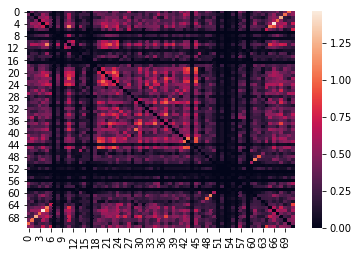

In [284]:
sns.heatmap(col_info(align, nucl='T'))

Участки комплиментарности все так же прослеживаются, но появились куда более высокие по абсолютной величине значения, и в целом картинка стала ярче. Это ожидаемый результат, поскольку теперь мы рассматриваем молекулы представителей одного вида!

# 2. Nussinov

In [159]:
# Escherichia coli tRNA
RNA = 'GGGGCUAUAGCUCAGCUGGGAGAGCGCCUGCUUUGCACGCAGGAGGUCUGCGGUUCGAUCCCGCAUAGCUCCACCA'

In [160]:
ind = {'A': 0, 'U': 1, 'G': 2, 'C': 3}
w = [[0,1,0,0], [1,0,1,0], [0,1,0,1], [0,0,1,0]] # матрица комплиментарности пар нуклеотидов

In [161]:
def Nuss(s, w, min_hp=3):     # min_hp - минимальный размер шпильки
    n = len(s)
    M = np.zeros((n,n), dtype=np.int)
    
    # динамическое заполнение матрицы наилучших вариантов укладки
    for d in range(n-1):
        i, j = 0, min_hp + d
        while j < n:
            K = np.empty(j-i, dtype=np.int)
            for k in range(i,j):
                K[i-k] = M[i,k] + M[k+1,j]
            M[i,j] = max(M[i+1,j-1] + w[ind[s[i]]][ind[s[j]]] ,np.max(K))
            i += 1
            j += 1
    
    # восстановление решения
    stack = [(0,n-1)]
    pairs = []
    while len(stack):
        i, j = stack.pop()
        if j-i <= min_hp:
            continue
        elif M[i,j] == M[i+1, j-1] + w[ind[s[i]]][ind[s[j]]]:
            pairs.append((i,j))
            stack.append((i+1, j-1))
        else:
            for k in range(i,j):
                if M[i,j] == M[i,k] + M[k+1,j]:
                    stack.append((i, k))
                    stack.append((k+1,j))
                    break
    pairs.sort()
    
    # представление решения
    struct = ['-']*n
    for i, j in pairs: 
        struct[i] = '('
        struct[j] = ')'
        
    print(s)
    print(*struct, sep='')
    
    return M[0,-1]

In [162]:
Nuss(RNA, w)

GGGGCUAUAGCUCAGCUGGGAGAGCGCCUGCUUUGCACGCAGGAGGUCUGCGGUUCGAUCCCGCAUAGCUCCACCA
(((((----))))--)((((-(((((((-((((((----))))(----))))))(-(-(-----))))))))-)))


30

Попробуем использовать разные веса для разных пар нуклеотидов

In [169]:
w1 = [[0,2,0,0], [2,0,1,0], [0,1,0,3], [0,0,3,0]] # разные веса для разных пар нуклеотидов

Nuss(RNA, w1)
print()

GGGGCUAUAGCUCAGCUGGGAGAGCGCCUGCUUUGCACGCAGGAGGUCUGCGGUUCGAUCCCGCAUAGCUCCACCA
(((((----))))--)((((-((((((((-(((-(----)))))))-)(((((-------))))--))))))-)))



Результат изменился, но не принципиально

### Test 1

In [166]:
Nuss('GGACC', w)

GGACC
(---)


1

### Test 2

In [167]:
Nuss('AAACAUGAGGAUUACCCAUGU', w)

AAACAUGAGGAUUACCCAUGU
(--((((((-----)))))))


7